### In this version of the model, cells are randomly assigned one of the two states having different growth rates

#### Red refers to cells expressing RFP and yellow referes to cells expressing YFP. Cells are randomly assigned identities without any lineage history. In an alternate model, we will assign cell type based on lineage history. 

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy as sp
from pylab import *
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.algorithms import bipartite
import random as rd
from collections import Counter
import pylab 
import scipy.stats as stats
import warnings
import matplotlib.animation as animation

warnings.filterwarnings('ignore')


In [2]:
#Function for drawing radial graphs in NetworkX library
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [3]:
#Counting the number of clusters and composition of cluster (cells per cluster)
def module_counter():
    global g
    cluster_counter=0
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==0):
            cluster_counter=cluster_counter+1
            for n in g.nodes():
                if(n.endswith(e[1][1:])):
                    g.nodes[n]['clust']=str(cluster_counter)

In [4]:
#Calculation of Kullback-Leibler Divergence between the experimental and model derived distribution
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [5]:
#Count the distribution of number of cells per cluster and also fraction of red/yellow cells
def count_freq(g):
    clust_information=[]
    ctype=[]
    for n in g.nodes():
        clust_information.append(g.nodes[n]['clust'])
        ctype.append(g.nodes[n]['type'])
    return clust_information,ctype

In [6]:
def graph_snap(t,sim_time):
    for n in g.nodes():
        g.nodes[n]['snap_time']=int(str(n)[1])
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==1):
            g.edges[e[0],e[1]]['snap_time']=int(e[1][1])-1
        else:
            g.edges[e[0],e[1]]['snap_time']=sim_time

In [7]:

def break_cluster(t,max_node):
    global g
    cluster_counter=0
    degree_list=[]
    
    for e in g.edges():
        if(t>=g.edges[e[0],e[1]]['t_break'] and (g.edges[e[0],e[1]]['break']!=0)):
            g.edges[e[0],e[1]]['break']=0


    node_list=[node for node in g.nodes()]
    for node in node_list:
        edges_temp=g.edges(node)
        break_list=[g.edges[ed[0],ed[1]]['break'] for ed in edges_temp]
        degree_list.append(sum(break_list))
    max_nodes = [node_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    max_degrees = [degree_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    
    for i,node in enumerate(max_nodes):
        if(max_degrees[i]>=max_node):
            edges=[edge for edge in g.edges(node) if g.edges[edge[0],edge[1]]['break']!=0]
            edge_bt=[g.edges[e[0],e[1]]['t_break'] for e in edges]
            for k,bt in enumerate(edge_bt): 
                if(np.round(bt,0)>=t):
                    edge_tbb=edges[k]
                    g.edges[edge_tbb[0],edge_tbb[1]]['break']=0    

         

        

In [8]:
def doubling_time_generator():
    x1=np.random.normal(2,0.001,100)
    x2=np.random.normal(4,0.001,100)
    x_bim=np.concatenate([x1,x2])
    return np.round(np.random.choice(x_bim)).astype('int')

In [9]:
def grow(t,mbt,p,ctype):
    global g
    
    nextg=g.copy()
    for n in g.nodes():
        if(g.nodes[str(n)]['type']==ctype):
            new_node='Y'+str(t)+'_'+str(n)[1:] #Naming daughter cells to track lineage information
            nextg.add_edge(str(n),new_node) #Growth
            nextg.nodes[new_node]['clust']=nextg.nodes[str(n)]['clust'] #Inherit the cluster information
            if(nextg.nodes[str(n)]['type']=='red'):
                nextg.nodes[new_node]['type']='red'
            else:
                nextg.nodes[new_node]['type']=np.random.choice(['red','yellow'],p=[p,1-p])
                
            nextg.edges[str(n),new_node]['break']=1
            nextg.edges[str(n),new_node]['t_break']=t+np.random.exponential(scale=mbt)
    g=nextg



In [10]:
def init_system(p):
    global g
    g=nx.Graph() #Initialization 
    g.add_node('Y0') #Mother yeast cell 
    g.nodes['Y0']['clust']='0'
    g.nodes['Y0']['type']='yellow'
    nextg=g.copy()

In [11]:
#Main function to call other functions associated with dissociation of the cluster, counting of cells per custer
#p is the conversion rate from yellow to red
#dt1 and dt2 are doubling times for yellow and red
def clust_form_and_break(sim_time,max_node,mbt,p,dt1,d):
    global g
    
    init_system(p)
    
    for t in range(sim_time):
        if(int(t%dt1)==0): 
            grow(t,mbt,p,'yellow')
        if(int(t%(dt1+d))==0):
            grow(t,mbt,p,'red')
        break_cluster(t,max_node)    
    module_counter()
    
    return g

# eEMC012 (Figure 6)

### Stable fraction vs Doubling time difference

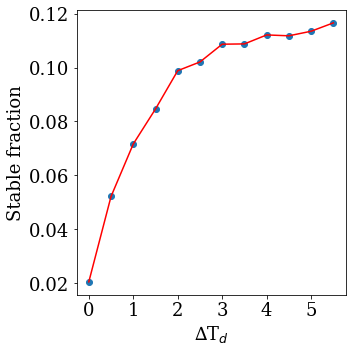

In [12]:
mix_array=[]
diff_array=[]
mix=[]
size=[]
for d in range(12): 

    p=0.15 #Conversion Rate
    kn=3 #Kissing Number
    diff=d/2 #Doubling time difference
    
    for i in range(1):
        g=clust_form_and_break(20,kn,100,p,2,diff)
        count,ctype=count_freq(g)
        cells=pd.DataFrame({'Cluster':count,'Type':ctype})
        cells['Identity']=cells['Type'].apply(lambda x:1 if x=='yellow' else 0)

        fracs=[]
        clust_size=[]
        for m in cells['Cluster'].unique():
            fracs.append(sum(cells.loc[cells['Cluster']==m,'Identity'])/len(cells.loc[cells['Cluster']==m,'Identity']))
            clust_size.append(len(cells.loc[cells['Cluster']==m,'Identity']))

        frac_arr=np.array(fracs)
        clust_arr=np.array(clust_size)

        frac_arr_red=sum(frac_arr==1.0)
        frac_arr_yellow=sum(frac_arr==0.0)
        frac_arr_mix=len(frac_arr)-frac_arr_red-frac_arr_yellow
        mix.append(frac_arr_mix/len(frac_arr))
    
    mix_array.append(np.mean(mix))
    diff_array.append(d/2)



plt.rc('font',family='serif')
plt.figure(figsize=(5,5))
plt.scatter(diff_array,mix_array)
plt.plot(diff_array,mix_array,color='red')
plt.xlabel(r'∆T$_{d}$',fontsize=18)
plt.ylabel(r'Stable fraction',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

# plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/Fraction_vs_delt.jpg',dpi=600)

## Stable fraction vs Kissing Number Difference

In [13]:
p=0.1
u=1.5

kiss=[]
mix=[]
red=[]
yellow=[]
size=[]
mix_array0=[]
red_array0=[]
yellow_array0=[]


for kn in range(2,11): 

#     p=0.125 #Conversion Rate
    diff=0.0 #Doubling time difference
    
    for i in range(3):
        g=clust_form_and_break(int(10*u),kn,100,p,u,diff)
        count,ctype=count_freq(g)
        cells=pd.DataFrame({'Cluster':count,'Type':ctype})
        cells['Identity']=cells['Type'].apply(lambda x:1 if x=='yellow' else 0)

        fracs=[]
        clust_size=[]
        for m in cells['Cluster'].unique():
            fracs.append(sum(cells.loc[cells['Cluster']==m,'Identity'])/len(cells.loc[cells['Cluster']==m,'Identity']))
            clust_size.append(len(cells.loc[cells['Cluster']==m,'Identity']))

        frac_arr=np.array(fracs)
        clust_arr=np.mean(clust_size)

        frac_arr_red=sum(frac_arr==1.0)
        frac_arr_yellow=sum(frac_arr==0.0)
        frac_arr_mix=len(frac_arr)-frac_arr_red-frac_arr_yellow
        mix.append(frac_arr_mix/len(frac_arr))
        red.append(frac_arr_red/len(frac_arr))
        yellow.append(frac_arr_yellow/len(frac_arr))
        
    size.append(np.mean(clust_arr))
    mix_array0.append(np.mean(mix))
    red_array0.append(np.mean(red))
    yellow_array0.append(np.mean(yellow))
    kiss.append(int(kn))



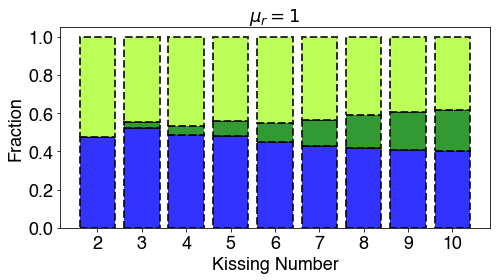

In [16]:
a=0.8
plt.rc('font',family='helvetica')
plt.figure(figsize=(7,4))
plt.bar(kiss, red_array0, color='blue',edgecolor='black',linewidth=2,linestyle='--',alpha=a)
plt.bar(kiss, mix_array0, bottom=red_array0, color='green',edgecolor='black',linewidth=2,linestyle='--',alpha=a)
plt.bar(kiss, yellow_array0, bottom=np.array(mix_array0)+np.array(red_array0), color='greenyellow',edgecolor='black',linewidth=2,linestyle='--',alpha=a)
plt.xlabel(r'Kissing Number',fontsize=18)
plt.ylabel(r'Fraction',fontsize=18)
plt.xticks(ticks=[2,3,4,5,6,7,8,9,10],fontsize=18)
plt.yticks(fontsize=18)
plt.title('$\mu_{r}=1$',fontsize=18)
plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/low_diff_fraction.jpg',dpi=1000)

In [15]:
kiss=[]
mix=[]
red=[]
yellow=[]
size=[]
mix_array2=[]
red_array2=[]
yellow_array2=[]

for kn in range(2,11): 

    p=0.125 #Conversion Rate
    diff=0.7 #Doubling time difference
    
    for i in range(3):
        g=clust_form_and_break(int(7*u),kn,16,p,u,diff)
        count,ctype=count_freq(g)
        cells=pd.DataFrame({'Cluster':count,'Type':ctype})
        cells['Identity']=cells['Type'].apply(lambda x:1 if x=='yellow' else 0)

        fracs=[]
        clust_size=[]
        for m in cells['Cluster'].unique():
            fracs.append(sum(cells.loc[cells['Cluster']==m,'Identity'])/len(cells.loc[cells['Cluster']==m,'Identity']))
            clust_size.append(len(cells.loc[cells['Cluster']==m,'Identity']))

        frac_arr=np.array(fracs)
        clust_arr=np.mean(clust_size)

        frac_arr_red=sum(frac_arr==1.0)
        frac_arr_yellow=sum(frac_arr==0.0)
        frac_arr_mix=len(frac_arr)-frac_arr_red-frac_arr_yellow
        mix.append(frac_arr_mix/len(frac_arr))
        red.append(frac_arr_red/len(frac_arr))
        yellow.append(frac_arr_yellow/len(frac_arr))

    size.append(np.mean(clust_arr))
    mix_array2.append(np.mean(mix))
    red_array2.append(np.mean(red))
    yellow_array2.append(np.mean(yellow))
    kiss.append(int(kn))

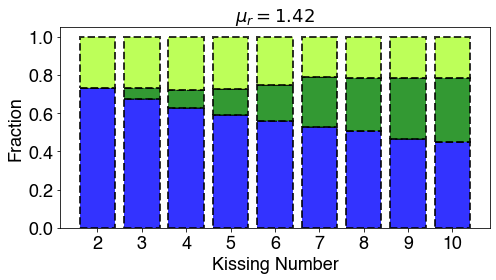

In [17]:
a=0.8
plt.rc('font',family='helvetica')
plt.figure(figsize=(7,4))
plt.bar(kiss, red_array2, color='blue',edgecolor='black',linewidth=2,linestyle='--',alpha=a)
plt.bar(kiss, mix_array2, bottom=red_array2, color='green',edgecolor='black',linewidth=2,linestyle='--',alpha=a)
plt.bar(kiss, yellow_array2, bottom=np.array(mix_array2)+np.array(red_array2), color='greenyellow',edgecolor='black',linewidth=2,linestyle='--',alpha=a)
plt.xlabel(r'Kissing Number',fontsize=18)
plt.ylabel(r'Fraction',fontsize=18)
plt.xticks(ticks=[2,3,4,5,6,7,8,9,10],fontsize=18)
plt.yticks(fontsize=18)
plt.title('$\mu_{r}=1.42$',fontsize=18)
plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/high_diff_fraction.jpg',dpi=1000)